In [5]:
using DifferentialEquations
using Plots
using Statistics
using LinearAlgebra
using DiffEqParamEstim

In [8]:
phi(a, gamma_a) = a ./ (a + gamma_a)

phi (generic function with 1 method)

In [ ]:
function f_old(du,u,p0,t)
    B, E, M, a, h, p = u
    betaa, betab, betaE1, betaE2, betah1, betah2, betaM1, betaM2, betap, gammaa, gammaB, gammah, gammap, muaE, muaM, muhM, mupB, mupE, q = p0

    du[1]= betab.*phi(u[6],gammap).*u[1] - q.*u[1]
    du[2] = (betaE1.*phi(u[4], gammaa) + betaE2.*(1-phi(u[1], gammaB)).*phi(u[6], gammap)).*u[2] - q.*u[2]
    du[3] = (betaM1.*phi(u[4], gammaa) + betaM2.*phi(u[5], gammah)).*u[3] - q.*u[3]

    du[4] = betaa.*phi(u[6], gammap).*u[1] - q.*u[4] - (muaE.*u[2] + muaM.*u[3]).*u[4]
    du[5] = betah1.*phi(u[4], gammaa).*u[2] + betah2.*phi(u[6], gammap).*u[1] - q.*u[5] - muhM.*u[5].*u[3]
    du[6] = betap.*q.*(cos.(t)+1).^3 - q.*u[6] - (mupB.*u[1] + mupE.*u[2]).*u[6]
end


In [9]:
function f(du,u,p0,t)
    B, E, M, a, h, p = u
    betaa, betab, betaE1, betaE2, betah1, betah2, betaM1, betaM2, betap, gammaa, gammaB, gammah, gammap, muaE, muaM, muhM, mupB, mupE, q = p0

    du[1]= betab.*phi(p,gammap).*B - q.*B
    du[2] = (betaE1.*phi(a, gammaa) + betaE2.*(1-phi(B, gammaB)).*phi(p, gammap)).*E - q.*E
    du[3] = (betaM1.*phi(a, gammaa) + betaM2.*phi(h, gammah)).*M - q.*M

    du[4] = betaa.*phi(p, gammap).*B - q.*a - (muaE.*E + muaM.*M).*phi(a, gammaa)
    du[5] = betah1.*phi(a, gammaa).*E + betah2.*phi(p, gammap).*B - q.*h- muhM.*phi(h, gammah).*M
    du[6] = betap.*q.*(cos.(t)+1).^3 - q.*p - (mupB.*B + mupE.*E).*phi(p, gammap)
end

f (generic function with 1 method)

In [10]:
# betaa, betab, betaE1, betaE2, betah1, betah2, betaM1, betaM2, betap, gammaa, gammaB, gammah, gammap, muaE, muaM, muhM, mupB, mupE, q
u0 = [0.0004706; 0.0004706; 0.0004706; 9.7079; 7.9551; 32.061]
tspan = (0.0,500.0);
p = [0.5, # betaa
    0.5, # betab
    0.5, # betaE1
    0.5, # betaE2
    0.5, #betah1
    0.5, #betah2
    0.5, #betaM1
    0.5, #betaM2
    30, #betap
    10, #gammaa
    1e-4, # gammaB
    10, #gammah
    30, # gammap
    0.5, # muaE
    0.5, # muaM
    0.5, # muhM
    0.5, #mupB
    0.5, #mupE
    0.1] # q

# solve the ODE
prob = ODEProblem(f,u0,tspan,p)
sol = solve(prob)#, Rosenbrock23())


retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 1174-element Vector{Float64}:
   0.0
   0.1292603734559461
   0.49278002735943416
   1.0232518710312224
   1.7805733324098165
   2.539019411089105
   3.661890738602046
   5.0430918585417475
   6.217486404904622
   7.692365172729993
   9.087014241966576
  10.901367786761265
  12.564049650710901
   ⋮
 495.45745056540943
 495.7829346249908
 496.14709260161527
 496.5774551325149
 497.1717954422226
 497.593948121872
 498.0983547532976
 498.600573644566
 498.94106644413324
 499.3198475548347
 499.6689288813786
 500.0
u: 1174-element Vector{Vector{Float64}}:
 [0.0004706, 0.0004706, 0.0004706, 9.7079, 7.9551, 32.061]
 [0.0004806426470470198, 0.00048237826484535614, 0.0004934126798553247, 9.583208718857717, 7.85295125120527, 34.71862479507934]
 [0.0005131136973662789, 0.0005167465073572191, 0.0005624217988398259, 9.241056923377792, 7.572659299702324, 41.38353

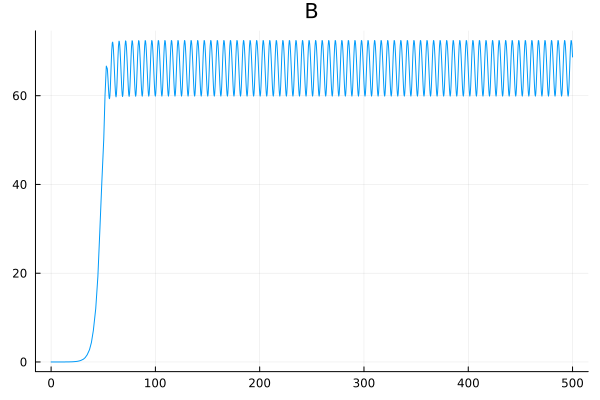

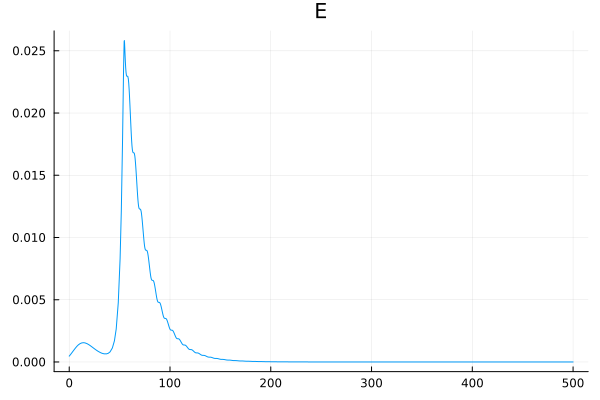

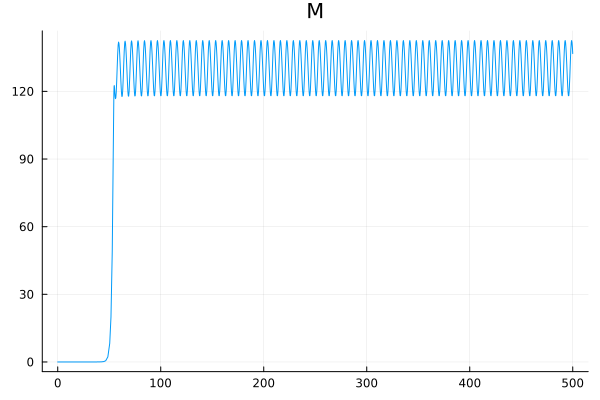

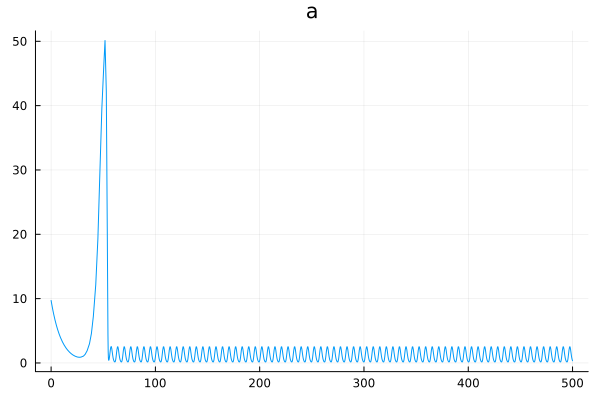

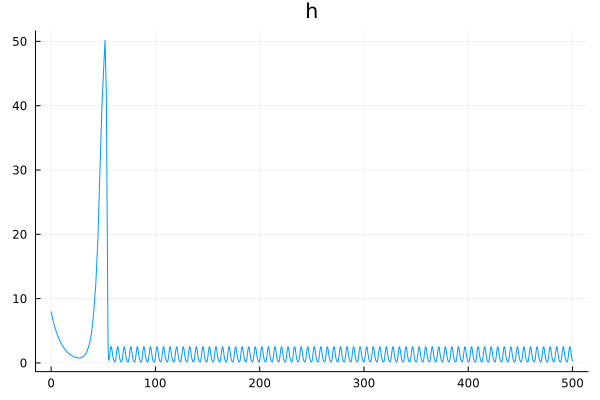

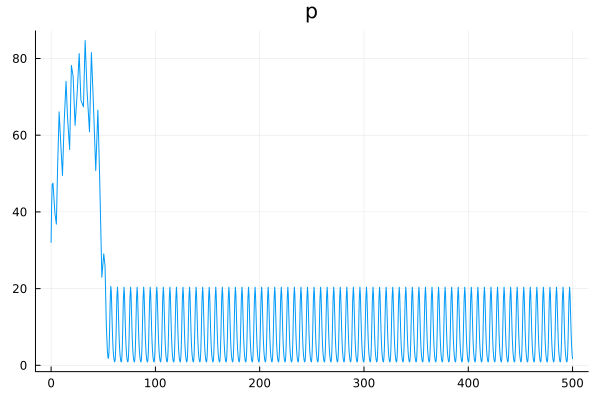

In [11]:
vars = ['B', "E", "M", "a", "h", "p"]
for i in 1:6
    d = plot(sol.t, sol[i,:], title = vars[i], legend = false)
    display(d)
end

In [12]:
mean(sol[:,400:500], dims=2)

6×1 Matrix{Float64}:
  66.39515512839849
   1.0023795685173582e-5
 130.64824190420575
   1.0710340884277076
   1.0710342778369144
   7.750224286383615

# Loss function

In [13]:
truth = u0; t_start = 400; t_end = 500; weight = u0
function loss(sol)#, truth, t_start, t_end, weight)
    """ loss computes a weighted mean squared error loss between a prediction (averaged across timepoints t_start to t_end) and ground truth weighted by a weight vector
    truth (Vector): vector containing the ground truth
    pred (Matrix): matrix with shape (variables, timepoints)
    t_start (integer): first timepoint to pull to compute an average across time
    t_end (integer): last timepoint to pull to compute an average across time
    """
    return sum((truth-mean(sol[:,t_start:t_end], dims=2)).^2 ./weight )#(u0-mean(sol[:,t_start:t_end], dims=2))./ weight
end

loss (generic function with 1 method)

In [14]:
loss(sol)#,sol,400,500,u0)

4.5637716479418255e7

In [23]:
(1 ./u0- 1 ./mean(sol[:,400:500], dims=2)).^2 .* u0#./u0

6×1 Matrix{Float64}:
 2124.916753755018
    4.486282920037827e6
 2124.9315680746568
    6.698544904952472
    5.193230889527789
    0.30689656489143713

KeyError: KeyError: key "usage_request" not found

# Parameter Estimation

In [16]:
using Distributions
using Turing
using Random
Random.seed!(14);

KeyError: KeyError: key "usage_request" not found

KeyError: KeyError: key "usage_request" not found

KeyError: KeyError: key "usage_request" not found

KeyError: KeyError: key "usage_request" not found

KeyError: KeyError: key "usage_request" not found

KeyError: KeyError: key "usage_request" not found

KeyError: KeyError: key "usage_request" not found

KeyError: KeyError: key "usage_request" not found

KeyError: KeyError: key "usage_request" not found

KeyError: KeyError: key "usage_request" not found

In [1]:
@model function fit(data, prob)
    # Prior distributions.
    σ ~ InverseGamma(2, 3)
    betaa
    betab
    betaE1
    betaE2
    betah1
    betah2
    betaM1
    betaM2
    betap
    gammaa
    gammaB
    gammah
    gammap
    muaE
    muaM
    muhM
    mupB
    mupE
    q 
    
    
    p = [betaa, betab, betaE1, betaE2, betah1, betah2, betaM1, betaM2, betap, gammaa, gammaB, gammah, gammap, muaE, muaM, muhM, mupB, mupE, q ]
    predicted = solve(prob, Tsit5(); p=p, saveat=0.1)

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end

model = fit(data, prob)

# Sample 3 independent chains with forward-mode automatic differentiation (the default).
chain = sample(model, NUTS(0.65), MCMCSerial(), 1000, 3; progress=false)